# 基于LangGraph的智能深度研究代理

## 需求分析

在当今信息爆炸的时代，研究人员、学生和分析师在进行深度课题研究时面临着严峻的挑战。传统的“人工研究”模式存在以下痛点：

1. **耗时巨大 (Time-Consuming)**: 手动搜索、筛选、阅读和整合大量文献资料是一个极其耗时的过程，占据了研究人员大部分的精力。
2. **信息过载 (Information Overload)**: 面对海量的网络信息，如何快速识别高质量、高相关性的内容成为一大难题。研究者容易迷失在信息的海洋中，效率低下。
3. **综合困难 (Difficulty in Synthesis)**: 将来自不同来源、不同视角的信息进行有效整合，形成一个逻辑清晰、观点明确的综合报告，对研究者的认知能力要求极高，且容易产生主观偏见。
4. **交互性差 (Poor Interactivity)**: 传统研究工具是单向的。研究者无法与研究过程进行动态交互，例如在初步计划后进行调整，或对中间结果提出反馈。

我们的智能深度研究代理旨在解决以上痛点。它利用大型语言模型（LLM）的强大能力，将复杂的研究任务自动化，通过多轮交互让用户参与和指导研究过程，最终高效地生成一份结构化、有深度的研究报告。

## 系统分析与设计
本系统被设计为一个**循环式、有状态的图（Graph）**，其中每个**节点（Node）**代表研究流程中的一个具体步骤。信息在图中以一个共享的**状态（State）**对象进行传递和更新。

### 系统架构
我们将整个研究流程拆分为几个核心的、可复用的智能体节点，并用LangGraph将它们连接起来。

1. **Planner (规划器)**:
- 输入: 用户的初始研究课题。
- 功能: 调用LLM，将模糊的课题分解成一个清晰、有序的研究计划（例如，一个包含多个具体子问题的列表）。
- 输出: 更新状态，添加研究计划。

2. **Web_Searcher (网络搜索器)**:
- 输入: 研究计划中的每一个子问题。
- 功能: 使用专为LLM优化的搜索引擎（如Tavily API）执行网络搜索，获取与子问题最相关的网页URL列表。
- 输出: 更新状态，为每个子问题关联一个URL列表。

3. **Content_Extractor (内容提取器)**:
- 输入: 搜索到的URL列表。
- 功能: 遍历URL，使用requests库获取网页HTML，再用BeautifulSoup4库提取出干净、无干扰的文本内容。
- 输出: 更新状态，存储所有页面的纯文本内容。

4. **Information_Synthesizer (信息综合器)**:
- 输入: 所有提取到的文本内容。
- 功能: 这是系统的核心大脑。它调用LLM，对所有零散信息进行阅读、去重、提炼、总结和交叉引用，形成一份逻辑连贯的草稿。
- 输出: 更新状态，生成研究草稿。

5. **Decision_Agent (判断智能体)**:
- 输入: 研究计划或研究草稿。
- 功能: 这是一个条件节点。在关键步骤后（如计划生成后），图会暂停执行 (interrupt)，等待用户输入反馈（如“继续”、“修改计划”）。这实现了对话管理与多轮交互。
- 输出: 根据用户指令，决定图的下一步走向。

6. **Report_Generator (报告生成器)**:
- 输入: 最终确认的综合信息。
- 功能: 调用LLM，将信息草稿格式化为一篇结构完整、排版精良的最终研究报告。
- 输出: 最终的研究报告。

Generating single mermaid chart


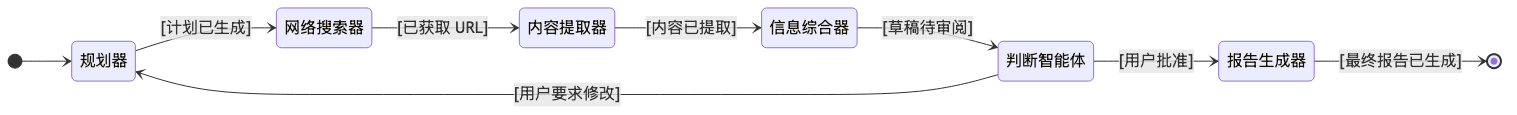

In [2]:
import subprocess, tempfile, os
from IPython.display import Image, display

mermaid_src = r"""
stateDiagram-v2
    direction LR
    [*] --> 规划器
    规划器 --> 网络搜索器: [计划已生成]
    网络搜索器 --> 内容提取器: [已获取 URL]
    内容提取器 --> 信息综合器: [内容已提取]
    信息综合器 --> 判断智能体: [草稿待审阅]
    判断智能体 --> 报告生成器: [用户批准]
    判断智能体 --> 规划器: [用户要求修改]
    报告生成器 --> [*]: [最终报告已生成]
"""

with tempfile.TemporaryDirectory() as tmpdir:
    in_file  = os.path.join(tmpdir, "graph.mmd")
    out_file = os.path.join(tmpdir, "graph.png")
    with open(in_file, "w", encoding="utf-8") as f:
        f.write(mermaid_src)

    # 分辨率 ×2（3200×800）；数值可再调大
    subprocess.run(
        ["mmdc", "-i", in_file, "-o", out_file,
         "-b", "transparent", "-w", "3200", "-H", "800"],
        check=True
    )

    # notebook 中按 50% 缩放显示即可更清晰
    display(Image(out_file, width=1600))

In [71]:
!pip install -qU langgraph langchain langchain_openai tavily-python beautifulsoup4

In [80]:
import os
import json
from dotenv import load_dotenv
from typing import TypedDict, List, Optional
import requests
from bs4 import BeautifulSoup
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from IPython.display import Markdown

load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_BASE"] = os.getenv("OPENAI_API_BASE")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [73]:
class ResearchState(TypedDict):
    """定义研究流程中传递的共享状态"""
    query: str                               # 初始研究课题
    plan: Optional[List[str]]                # 研究计划
    search_results: Optional[List[dict]]     # 网络搜索结果
    extracted_content: Optional[List[str]]   # 提取的网页内容
    synthesis: Optional[str]                 # 信息综合后的草稿
    report: str                              # 最终的研究报告

In [74]:
search_tool = TavilySearchResults(max_results=3)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [90]:
def planner_node(state: ResearchState) -> dict:
    """规划器：根据用户问题生成研究计划"""
    print(">> 节点: 规划器 (Planner)")
    prompt = f"为研究课题 '{state['query']}' 制定一个清晰、分步的研究计划。"
    plan_str = llm.invoke(prompt).content
    plan = [p.strip() for p in plan_str.split('\n') if p.strip()]
    return {"plan": plan}

def web_searcher_node(state: ResearchState) -> dict:
    """网络搜索器：根据计划执行搜索"""
    print(">> 节点: 网络搜索器 (Web_Searcher)")
    plan_text = " ".join(state['plan'])
    prompt = (
        "请把下面的研究子任务概括为一个不超过 180 字符的搜索查询：\n"
        f"{plan_text}\n\n查询："
    )
    query = llm.invoke(prompt).content.strip()

    results = search_tool.invoke(query)

    return {"search_results": results}

def content_extractor_node(state: ResearchState) -> dict:
    """内容提取器：从URL中抓取和清洗文本"""
    print(">> 节点: 内容提取器 (Content_Extractor)")
    content = []
    for result in state["search_results"]:
        try:
            response = requests.get(result['url'], timeout=5)
            soup = BeautifulSoup(response.content, 'html.parser')
            text = ' '.join(t.strip() for t in soup.stripped_strings)
            content.append(text[:3000]) # 截断以避免内容过长
        except requests.RequestException:
            continue # 忽略抓取失败的URL
    return {"extracted_content": content}

def information_synthesizer_node(state: ResearchState) -> dict:
    """信息综合器：整合所有信息，形成草稿"""
    print(">> 节点: 信息综合器 (Information_Synthesizer)")
    context = "\n\n---\n\n".join(state["extracted_content"])
    prompt = f"根据以下信息，为课题 '{state['query']}' 撰写一份逻辑连贯、内容全面的分析报告草稿。\n\n信息：\n{context}"
    synthesis = llm.invoke(prompt).content
    return {"synthesis": synthesis}

def report_generator_node(state: ResearchState) -> dict:
    """报告生成器：将草稿格式化为最终报告"""
    print(">> 节点: 报告生成器 (Report_Generator)")
    prompt = f"请将以下关于 '{state['query']}' 的研究草稿，整理成一篇结构清晰、排版专业的最终报告。\n\n草稿：\n{state['synthesis']}"
    report = llm.invoke(prompt).content
    return {"report": report}

def decision_agent_node(state: ResearchState) -> str:
    """判断智能体：模拟用户决策，决定下一步走向"""
    print(">> 节点: 判断智能体 (Decision_Agent)")
    print("\n---\n[ 研究草稿已生成，等待您的审核 ]\n---")
    display(Markdown(state['synthesis']))
    
    # 模拟交互式输入
    user_input = input("\n👉 请输入您的指令 ('y' 表示批准并生成最终报告, 'n' 表示不满意并重新规划): ").lower()
    
    if user_input == 'y':
        print("✅ 用户批准，流程将继续生成最终报告。")
        return "continue_to_report"
    else:
        print("🔄 用户要求修改，流程将返回规划器。")
        return "revise_plan"

In [91]:
workflow = StateGraph(ResearchState)

# 添加所有节点
workflow.add_node("Planner", planner_node)
workflow.add_node("Web_Searcher", web_searcher_node)
workflow.add_node("Content_Extractor", content_extractor_node)
workflow.add_node("Information_Synthesizer", information_synthesizer_node)
workflow.add_node("Report_Generator", report_generator_node)

# 设置图的入口
workflow.set_entry_point("Planner")

# 添加常规的有向边
workflow.add_edge("Planner", "Web_Searcher")
workflow.add_edge("Web_Searcher", "Content_Extractor")
workflow.add_edge("Content_Extractor", "Information_Synthesizer")

# 添加条件边，实现循环逻辑
workflow.add_conditional_edges(
    "Information_Synthesizer",       # 条件判断的起点
    decision_agent_node,             # 执行判断的智能体
    {
        "continue_to_report": "Report_Generator", # 如果返回 "continue_to_report"，则走向报告生成器
        "revise_plan": "Planner"                  # 如果返回 "revise_plan"，则返回规划器，形成循环
    }
)

# 添加结束边
workflow.add_edge("Report_Generator", END)

# 编译图，使其成为可执行的应用
app = workflow.compile()

In [92]:
if __name__ == '__main__':
    initial_query = {"query": "介绍一下火星探测的历史、主要发现和未来挑战"}
    
    # 执行工作流
    final_state = app.invoke(initial_query)
    
    # 显示最终报告
    if final_state.get('report'):
      print("\n\n====================\n   最终研究报告\n====================")
      display(Markdown(final_state['report']))

>> 节点: 规划器 (Planner)
>> 节点: 网络搜索器 (Web_Searcher)
>> 节点: 内容提取器 (Content_Extractor)


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


>> 节点: 信息综合器 (Information_Synthesizer)
>> 节点: 判断智能体 (Decision_Agent)

---
[ 研究草稿已生成，等待您的审核 ]
---


**分析报告草稿：火星探测的历史、主要发现和未来挑战**

**引言**

火星探测一直是人类太空探索的重要课题之一。作为太阳系中与地球最相似的行星，火星吸引了科学家们的极大兴趣。本文将回顾火星探测的历史，探讨主要的科学发现，并分析未来探测面临的挑战。

**一、火星探测的历史**

火星探测的历史可以追溯到20世纪60年代。1965年，美国的“水手4号”成为第一个成功飞越火星并传回照片的探测器，揭开了火星表面神秘的面纱。随后，苏联和美国相继发射了多次探测任务，包括“海盗号”和“火星探测者号”等，这些任务为我们提供了火星表面和大气的详细信息。

进入21世纪，火星探测进入了一个新的阶段。美国的“勇气号”和“机遇号”探测车在火星表面进行了长时间的科学考察，发现了火星曾经存在液态水的证据。近年来，“好奇号”和“毅力号”探测车继续在火星上进行科学研究，进一步揭示了火星的地质和气候历史。

**二、火星探测的主要发现**

1. **水的存在**：火星探测的一个重大突破是发现了水的存在。早期的探测任务发现了火星表面有干涸的河床和湖泊，暗示着火星曾经有过液态水。近年来，探测器在火星极地发现了水冰，并在地下探测到可能存在的液态水。

2. **地质活动**：火星上存在火山、峡谷和撞击坑等地质结构，显示出复杂的地质活动历史。探测器的研究表明，火星曾经有过剧烈的火山活动，这可能与其气候变化有关。

3. **大气和气候**：火星的大气主要由二氧化碳组成，且非常稀薄。探测任务揭示了火星气候的变化历史，显示出火星曾经可能有过较厚的大气层和温暖的气候。

**三、未来挑战**

1. **技术挑战**：火星探测面临的技术挑战包括长距离通信、探测器的自主导航和操作能力，以及在极端环境下的生存能力。未来的任务需要开发更先进的技术，以提高探测器的效率和可靠性。

2. **科学挑战**：尽管已经取得了许多重要发现，火星仍有许多未解之谜。例如，火星上是否存在过生命？其气候变化的具体机制是什么？这些问题需要更深入的科学研究来解答。

3. **人类探索**：将人类送上火星是未来探测的一个重要目标。人类火星任务面临的挑战包括长时间的太空旅行、火星环境的适应，以及资源的获取和利用。这些挑战需要国际合作和技术创新来解决。

**结论**

火星探测的历史充满了挑战和成就。通过不断的技术进步和科学研究，我们对火星的了解逐渐加深。然而，未来的探测任务仍面临许多技术和科学上的挑战。通过国际合作和创新，我们有望揭开火星的更多秘密，并最终实现人类登陆火星的梦想。

✅ 用户批准，流程将继续生成最终报告。
>> 节点: 报告生成器 (Report_Generator)


   最终研究报告


# 火星探测的历史、主要发现和未来挑战

## 引言

火星探测一直是人类太空探索的重要课题之一。作为太阳系中与地球最相似的行星，火星吸引了科学家们的极大兴趣。本文将回顾火星探测的历史，探讨主要的科学发现，并分析未来探测面临的挑战。

## 一、火星探测的历史

火星探测的历史可以追溯到20世纪60年代。1965年，美国的“水手4号”成为第一个成功飞越火星并传回照片的探测器，揭开了火星表面神秘的面纱。随后，苏联和美国相继发射了多次探测任务，包括“海盗号”和“火星探测者号”等，这些任务为我们提供了火星表面和大气的详细信息。

进入21世纪，火星探测进入了一个新的阶段。美国的“勇气号”和“机遇号”探测车在火星表面进行了长时间的科学考察，发现了火星曾经存在液态水的证据。近年来，“好奇号”和“毅力号”探测车继续在火星上进行科学研究，进一步揭示了火星的地质和气候历史。

## 二、火星探测的主要发现

1. **水的存在**：火星探测的一个重大突破是发现了水的存在。早期的探测任务发现了火星表面有干涸的河床和湖泊，暗示着火星曾经有过液态水。近年来，探测器在火星极地发现了水冰，并在地下探测到可能存在的液态水。

2. **地质活动**：火星上存在火山、峡谷和撞击坑等地质结构，显示出复杂的地质活动历史。探测器的研究表明，火星曾经有过剧烈的火山活动，这可能与其气候变化有关。

3. **大气和气候**：火星的大气主要由二氧化碳组成，且非常稀薄。探测任务揭示了火星气候的变化历史，显示出火星曾经可能有过较厚的大气层和温暖的气候。

## 三、未来挑战

1. **技术挑战**：火星探测面临的技术挑战包括长距离通信、探测器的自主导航和操作能力，以及在极端环境下的生存能力。未来的任务需要开发更先进的技术，以提高探测器的效率和可靠性。

2. **科学挑战**：尽管已经取得了许多重要发现，火星仍有许多未解之谜。例如，火星上是否存在过生命？其气候变化的具体机制是什么？这些问题需要更深入的科学研究来解答。

3. **人类探索**：将人类送上火星是未来探测的一个重要目标。人类火星任务面临的挑战包括长时间的太空旅行、火星环境的适应，以及资源的获取和利用。这些挑战需要国际合作和技术创新来解决。

## 结论

火星探测的历史充满了挑战和成就。通过不断的技术进步和科学研究，我们对火星的了解逐渐加深。然而，未来的探测任务仍面临许多技术和科学上的挑战。通过国际合作和创新，我们有望揭开火星的更多秘密，并最终实现人类登陆火星的梦想。

## 改进点
1. 问题递归分解
2. 在线搜索引用